## 🧪❄️ Sistema Inteligente de Previsão de Estoque para Medicamentos Termolábeis ##

Produtos termolábeis exigem controle rigoroso de temperatura, validadee nível de estoque. 
Pequenos desvios podem gerar perdas financeiras e riscos assistenciais.
Este projeto tem como objetivo:
- Identificar produtos com maior risco operacional
- Antecipar perdas
- Priorizar ações com base em alertas explicáveis

## 1. Carregamento e Preparação dos Dados

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px 

In [144]:
df = pd.read_csv("dataset_termolabeis_completo_custom.csv") #importando dataset

In [145]:
df.info() # informacoes principais do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   produto              50 non-null     object 
 1   lote                 50 non-null     object 
 2   data_entrada         50 non-null     object 
 3   data_validade        50 non-null     object 
 4   temperatura_real     50 non-null     float64
 5   sazonalidade         50 non-null     object 
 6   estoque_atual        50 non-null     int64  
 7   consumo_mensal       50 non-null     int64  
 8   preco_unitario       50 non-null     float64
 9   margem               50 non-null     float64
 10  risco_validade       50 non-null     object 
 11  risco_ruptura        50 non-null     object 
 12  risco_tempo          50 non-null     object 
 13  nivel_estoque        50 non-null     object 
 14  perdas_registradas   50 non-null     int64  
 15  valor_total_estoque  50 non-null     float

# Entendimento do Dataset
- temperatura_real: temperatura registrada no armazenamento
- dias_para_vencer: tempo restante até a validade em dias
- perdas_registradas: quantidade em unidades perdidas 
- consumo_mensal: quantidade em unidades vendida por mes
- valor_total_estoque: valor total de todo o estoque
- estoque_atual: quantidade em estoque no momento
- sazonalidade: como o produto se comporta com o decorrer do tempo
- margem: margem de lucro do produto em relacao ao preco 

In [146]:
df.head(5) # listando 5 primeiras linhas do dataset

,produto,lote,data_entrada,data_validade,temperatura_real,sazonalidade,estoque_atual,consumo_mensal,preco_unitario,margem,risco_validade,risco_ruptura,risco_tempo,nivel_estoque,perdas_registradas,valor_total_estoque
0,Insulina NPH,L1000,2025-11-02,2026-03-14,7.7,Alta,33,13,1478.21,0.30,MEDIO,BAIXO,Normal,Baixo,4,48780.93
1,Insulina Regular,L1001,2025-08-14,2025-12-28,1.3,Alta,34,37,1212.00,0.27,ALTO,ALTO,ALTO,Alto,5,41208.00
2,Insulina Glargina,L1002,2025-07-14,2026-06-13,3.0,Baixa,40,56,1741.21,0.33,BAIXO,ALTO,Normal,Alto,1,69648.40
3,Insulina Detemir,L1003,2025-08-14,2026-06-04,3.5,Alta,102,26,222.38,0.21,MEDIO,BAIXO,Normal,Adequado,2,22682.76
4,Insulina Lispro,L1004,2025-09-24,2026-02-13,7.6,Baixa,20,29,176.02,0.19,ALTO,ALTO,Normal,Alto,5,3520.40


In [147]:
df.describe() # verificar médias, desvio padrão, máximos e mínimos para estoque, consumo, preços etc.

,temperatura_real,estoque_atual,consumo_mensal,preco_unitario,margem,perdas_registradas,valor_total_estoque
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,5.746000,58.840000,34.860000,926.261000,0.248800,2.660000,50844.656200
std,2.650777,35.819479,15.433875,595.832471,0.080626,1.709637,49940.571802
min,1.300000,7.000000,5.000000,23.350000,0.100000,0.000000,2009.280000
25%,3.500000,32.250000,26.000000,416.160000,0.190000,1.000000,15659.050000
50%,5.850000,53.500000,34.000000,954.375000,0.240000,3.000000,35935.530000
75%,7.700000,93.500000,47.000000,1439.057500,0.315000,4.000000,66754.957500
max,10.000000,120.000000,60.000000,1970.910000,0.390000,5.000000,224582.350000


In [148]:
df['data_entrada'] = pd.to_datetime(df['data_entrada'], dayfirst=True)
df['data_validade'] = pd.to_datetime(df['data_validade'], dayfirst=True) # corrigindo dataset para datetime quando datas 

In [149]:
df.info() # verificando se corrigiu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   produto              50 non-null     object        
 1   lote                 50 non-null     object        
 2   data_entrada         50 non-null     datetime64[ns]
 3   data_validade        50 non-null     datetime64[ns]
 4   temperatura_real     50 non-null     float64       
 5   sazonalidade         50 non-null     object        
 6   estoque_atual        50 non-null     int64         
 7   consumo_mensal       50 non-null     int64         
 8   preco_unitario       50 non-null     float64       
 9   margem               50 non-null     float64       
 10  risco_validade       50 non-null     object        
 11  risco_ruptura        50 non-null     object        
 12  risco_tempo          50 non-null     object        
 13  nivel_estoque        50 non-null     

In [150]:
df.isna().sum()

produto                0
lote                   0
data_entrada           0
data_validade          0
temperatura_real       0
sazonalidade           0
estoque_atual          0
consumo_mensal         0
preco_unitario         0
margem                 0
risco_validade         0
risco_ruptura          0
risco_tempo            0
nivel_estoque          0
perdas_registradas     0
valor_total_estoque    0
dtype: int64

In [151]:
df['dias_para_vencer'] = (df['data_validade'] - pd.Timestamp.today()).dt.days

In [152]:
df['dias_para_vencer'].head(5)

0     57
1    -19
2    148
3    139
4     28
Name: dias_para_vencer, dtype: int64

In [153]:
df.head(10)  # nova tabela com a coluna criada dias para vencer, mostrando os primeiros 10 items para checagem 

,produto,lote,data_entrada,data_validade,temperatura_real,sazonalidade,estoque_atual,consumo_mensal,preco_unitario,margem,risco_validade,risco_ruptura,risco_tempo,nivel_estoque,perdas_registradas,valor_total_estoque,dias_para_vencer
0,Insulina NPH,L1000,2025-11-02,2026-03-14,7.7,Alta,33,13,1478.21,0.30,MEDIO,BAIXO,Normal,Baixo,4,48780.93,57
1,Insulina Regular,L1001,2025-08-14,2025-12-28,1.3,Alta,34,37,1212.00,0.27,ALTO,ALTO,ALTO,Alto,5,41208.00,-19
2,Insulina Glargina,L1002,2025-07-14,2026-06-13,3.0,Baixa,40,56,1741.21,0.33,BAIXO,ALTO,Normal,Alto,1,69648.40,148
3,Insulina Detemir,L1003,2025-08-14,2026-06-04,3.5,Alta,102,26,222.38,0.21,MEDIO,BAIXO,Normal,Adequado,2,22682.76,139
4,Insulina Lispro,L1004,2025-09-24,2026-02-13,7.6,Baixa,20,29,176.02,0.19,ALTO,ALTO,Normal,Alto,5,3520.40,28
5,Vacina Tríplice Viral,L1005,2025-08-30,2026-10-19,2.7,Alta,10,47,471.24,0.19,BAIXO,ALTO,Normal,Baixo,0,4712.40,276
6,Vacina Hepatite B,L1006,2025-11-05,2026-09-15,3.5,Baixa,111,28,342.06,0.21,BAIXO,BAIXO,Normal,Adequado,5,37968.66,242
7,Vacina dT,L1007,2025-11-12,2027-01-17,6.7,Baixa,98,20,343.54,0.21,BAIXO,BAIXO,Normal,Alto,5,33666.92,366
8,Vacina Influenza,L1008,2025-10-05,2027-01-18,3.9,Alta,34,57,83.56,0.19,BAIXO,ALTO,Normal,Baixo,2,2841.04,367
9,Vacina Covid-19 Pfizer,L1009,2025-10-07,2026-11-21,8.9,Média,32,46,1008.48,0.37,BAIXO,ALTO,ALTO,Adequado,5,32271.36,309


## 2. Análise Exploratória de Dados

In [154]:
df['sazonalidade'].value_counts() 
# Verificando se existem produtos mais críticos em tempos sazonais

Alta     22
Baixa    17
Média    11
Name: sazonalidade, dtype: int64

In [155]:
df['risco_validade'].value_counts()
# Verificando se existem produtos risco de validade

BAIXO    35
MEDIO     8
ALTO      7
Name: risco_validade, dtype: int64

In [156]:
df['risco_ruptura'].value_counts()
# Verificando se existem produtos risco de ruptura/falta

BAIXO    29
ALTO     16
MEDIO     5
Name: risco_ruptura, dtype: int64

In [157]:
df['produto'].duplicated().sum() # verifica duplicatas (0)

0

In [158]:
df['produto'].unique() # lista todos os produtos

array(['Insulina NPH', 'Insulina Regular', 'Insulina Glargina',
       'Insulina Detemir', 'Insulina Lispro', 'Vacina Tríplice Viral',
       'Vacina Hepatite B', 'Vacina dT', 'Vacina Influenza',
       'Vacina Covid-19 Pfizer', 'Vacina Pneumocócica 23V',
       'Vacina Meningocócica C', 'Vacina HPV', 'Vacina Rotavírus',
       'Vacina Varicela', 'Somatropina', 'Adalimumabe', 'Etanercepte',
       'Tocilizumabe', 'Infliximabe', 'Eritropoetina', 'Filgrastim',
       'Palivizumabe', 'Teriparatida', 'Hormônio Tireoestimulante',
       'Insulina Degludeca', 'Insulina Aspart', 'Vacina Zoster',
       'Vacina Febre Amarela', 'Vacina Dengue Qdenga',
       'Vacina Poliomielite', 'Vacina Tétano', 'Vacina Coqueluche',
       'Vacina Hib', 'Vacina BCG', 'Insulina 70/30', 'Vacina Raiva',
       'Vacina ACWY', 'Vacina Pneumo 13V', 'Vacina Covid-19 Moderna',
       'Vacina Covid-19 Janssen', 'Vacina SCR', 'Vacina Hepatite A',
       'Vacina Hepatite A+B', 'Vacina DTPA', 'Vacina VIP', 'Vacina VOP',


In [159]:
df['produto'].nunique() # conta produtos únicos (50)

50

In [160]:
df['produto'].tail()

45                  Vacina VIP
46                  Vacina VOP
47                 Vacina MMRV
48           Vacina Pneumo 10V
49    Vacina Varíola Monkeypox
Name: produto, dtype: object

In [161]:
df['nivel_estoque'].value_counts()

Baixo       20
Adequado    15
Alto        15
Name: nivel_estoque, dtype: int64

In [162]:
df['data_validade'] = pd.to_datetime(df['data_validade'])
df['dias_para_vencer'] = (df['data_validade'] - pd.Timestamp.today()).dt.days

df[df['dias_para_vencer'] < 60][['produto','dias_para_vencer']] 
# Mostrando produtos que vão vencer em menos de 60 dias dando maior previsibilidade

,produto,dias_para_vencer
0,Insulina NPH,57
1,Insulina Regular,-19
4,Insulina Lispro,28
16,Adalimumabe,-62
20,Eritropoetina,48
29,Vacina Dengue Qdenga,-34
33,Vacina Hib,59
44,Vacina DTPA,28
46,Vacina VOP,25


In [163]:
df.sort_values(by="valor_total_estoque", ascending=False).head(10) #Top 10 em valor de estoque

,produto,lote,data_entrada,data_validade,temperatura_real,sazonalidade,estoque_atual,consumo_mensal,preco_unitario,margem,risco_validade,risco_ruptura,risco_tempo,nivel_estoque,perdas_registradas,valor_total_estoque,dias_para_vencer
41,Vacina SCR,L1041,2025-08-18,2026-10-29,7.7,Alta,115,15,1952.89,0.34,BAIXO,BAIXO,Normal,Baixo,3,224582.35,286
42,Vacina Hepatite A,L1042,2025-10-16,2026-08-02,8.0,Média,107,47,1730.85,0.34,BAIXO,BAIXO,Normal,Baixo,2,185200.95,198
13,Vacina Rotavírus,L1013,2025-11-28,2027-03-11,7.5,Baixa,118,39,1506.74,0.33,BAIXO,BAIXO,Normal,Baixo,2,177795.32,419
35,Insulina 70/30,L1035,2025-11-28,2027-03-04,8.4,Média,89,11,1879.08,0.14,BAIXO,BAIXO,ALTO,Baixo,0,167238.12,412
38,Vacina Pneumo 13V,L1038,2025-10-28,2027-01-17,9.8,Alta,99,33,1112.33,0.23,BAIXO,BAIXO,ALTO,Baixo,0,110120.67,366
27,Vacina Zoster,L1027,2025-10-07,2026-08-28,9.1,Alta,53,5,1970.91,0.18,BAIXO,BAIXO,ALTO,Adequado,3,104458.23,224
20,Eritropoetina,L1020,2025-10-04,2026-03-05,4.0,Baixa,75,19,1185.11,0.10,ALTO,BAIXO,Normal,Alto,5,88883.25,48
28,Vacina Febre Amarela,L1028,2025-08-14,2026-12-03,9.6,Baixa,89,50,983.61,0.16,BAIXO,BAIXO,ALTO,Baixo,1,87541.29,321
44,Vacina DTPA,L1044,2025-10-04,2026-02-13,6.9,Média,47,22,1731.42,0.39,ALTO,BAIXO,Normal,Adequado,2,81376.74,28
19,Infliximabe,L1019,2025-10-10,2026-07-16,4.6,Baixa,88,28,887.44,0.26,BAIXO,BAIXO,Normal,Baixo,0,78094.72,181


In [164]:
top_consumo = df.sort_values(by="consumo_mensal", ascending=False).head(10)
top_consumo[['produto','consumo_mensal','sazonalidade']] # Top 10 em consumo mensal com sazonalidades

,produto,consumo_mensal,sazonalidade
25,Insulina Degludeca,60,Média
24,Hormônio Tireoestimulante,60,Média
39,Vacina Covid-19 Moderna,58,Baixa
34,Vacina BCG,58,Alta
8,Vacina Influenza,57,Alta
2,Insulina Glargina,56,Baixa
26,Insulina Aspart,53,Alta
14,Vacina Varicela,51,Alta
46,Vacina VOP,51,Média
17,Etanercepte,51,Alta


In [165]:
media_por_sazonalidade = df.groupby("sazonalidade")["consumo_mensal"].mean()
media_por_sazonalidade # valores medios para sazonalidade 

sazonalidade
Alta     35.545455
Baixa    32.647059
Média    36.909091
Name: consumo_mensal, dtype: float64

In [166]:
df.groupby("sazonalidade")["consumo_mensal"].median() # # valores medios para sazonalidade visto que as medias anteriores para media e alta estavam muito proximas

sazonalidade
Alta     34.5
Baixa    31.0
Média    46.0
Name: consumo_mensal, dtype: float64

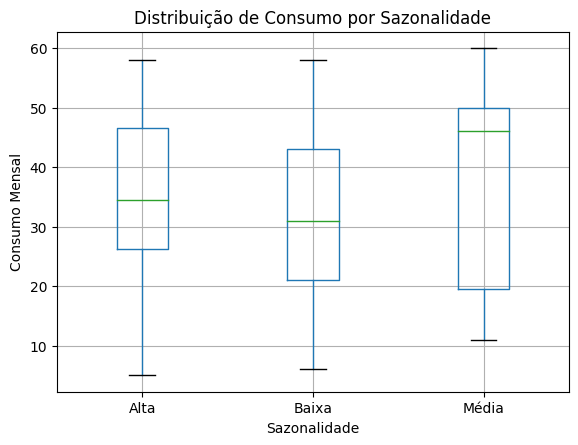

In [167]:
df.boxplot(column="consumo_mensal", by="sazonalidade")
plt.title("Distribuição de Consumo por Sazonalidade")
plt.suptitle("")
plt.xlabel("Sazonalidade")
plt.ylabel("Consumo Mensal")
plt.show()

In [168]:
df.groupby("produto")[["sazonalidade","consumo_mensal"]].mean().sort_values(by="consumo_mensal", ascending=False).head(10)
# Ranking dos produtos por sazonalidade e consumo

,consumo_mensal
produto,
Hormônio Tireoestimulante,60
Insulina Degludeca,60
Vacina Covid-19 Moderna,58
Vacina BCG,58
Vacina Influenza,57
Insulina Glargina,56
Insulina Aspart,53
Vacina Varicela,51
Etanercepte,51


In [169]:
 # produtos com sazonalidade baixa
df_baixa_sazon = df.loc[(df["sazonalidade"]=="Baixa") & (df["consumo_mensal"]>35), "produto"]
print (df_baixa_sazon)

2           Insulina Glargina
10    Vacina Pneumocócica 23V
13           Vacina Rotavírus
15                Somatropina
28       Vacina Febre Amarela
39    Vacina Covid-19 Moderna
48          Vacina Pneumo 10V
Name: produto, dtype: object


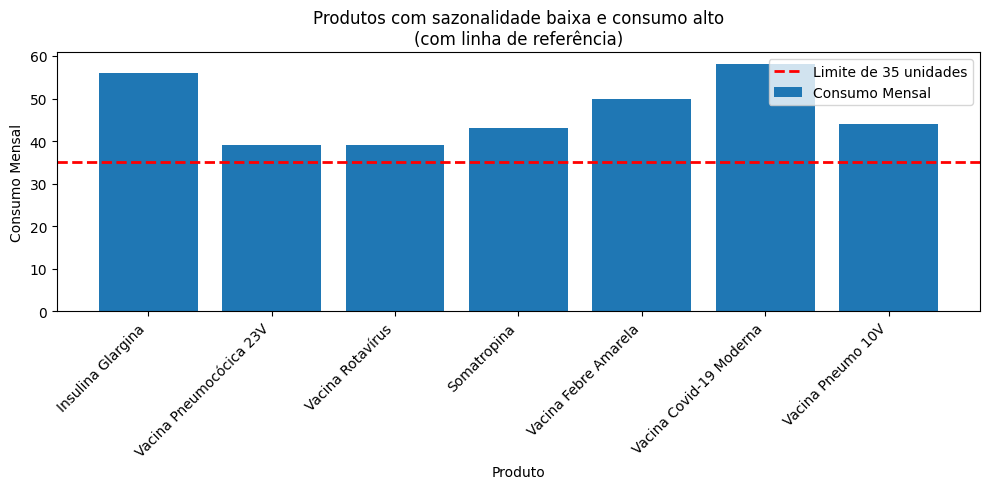

In [170]:
# Filtrar produtos: sazonalidade baixa + consumo > 35
filtered = df[(df["sazonalidade"]=="Baixa") & (df["consumo_mensal"]>35)]

plt.figure(figsize=(10,5))

# Barras
plt.bar(filtered["produto"], filtered["consumo_mensal"], label="Consumo Mensal")

# Linha limite
limite = 35
plt.axhline(limite, color="red", linestyle="--", linewidth=2, label=f"Limite de {limite} unidades")

plt.xticks(rotation=45, ha="right")
plt.title("Produtos com sazonalidade baixa e consumo alto\n(com linha de referência)")
plt.xlabel("Produto")
plt.ylabel("Consumo Mensal")
plt.legend()
plt.tight_layout()
plt.show()


Isso pode revelar uma possível classificação incorreta da sazonalidade, ou pode indicar o início de um padrão de consumo emergente, ou até podem ser produtos estáveis que têm consumo elevado independentemente da sazonalidade

In [171]:
# converter sazonalidade para valores numéricos
mapa = {"Baixa": 1, "Média": 2, "Alta": 3}
df["sazonalidade_num"] = df["sazonalidade"].map(mapa)

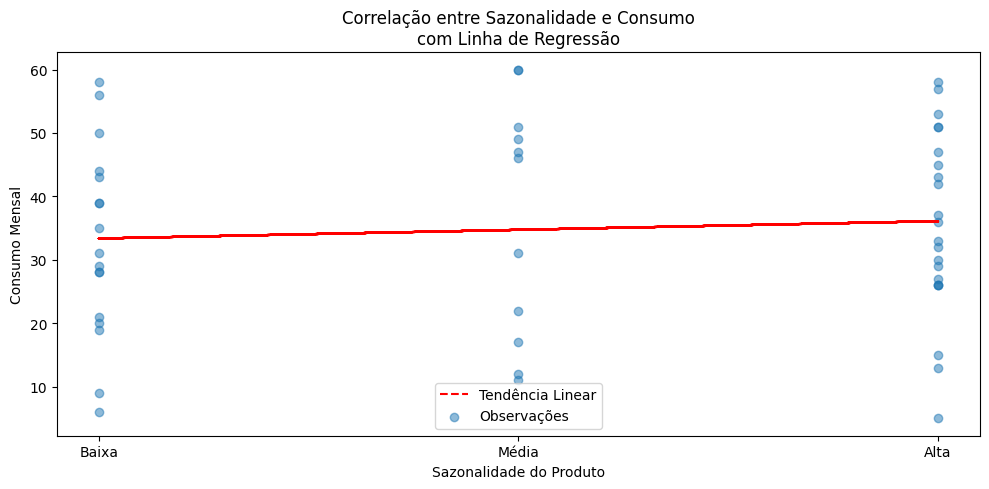

In [172]:
# extrair variáveis
x = df["sazonalidade_num"]
y = df["consumo_mensal"]

# calcular linha de regressão simples
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

plt.figure(figsize=(10,5))

# scatter plot
plt.scatter(x, y, alpha=0.5, label="Observações")

# regressão
plt.plot(x, poly1d_fn(x), '--', color="red", label="Tendência Linear")

# ajustes estéticos
plt.xticks([1,2,3], ["Baixa","Média","Alta"])
plt.xlabel("Sazonalidade do Produto")
plt.ylabel("Consumo Mensal")
plt.title("Correlação entre Sazonalidade e Consumo\ncom Linha de Regressão")

plt.legend()
plt.tight_layout()
plt.show()

In [173]:
# variável dependente (y)
y = df["consumo_mensal"]

# variável independente (x)
X = df["sazonalidade_num"]

# adicionar constante
X = sm.add_constant(X)

# ajustar modelo
modelo = sm.OLS(y, X).fit()

# mostrar resultados
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:         consumo_mensal   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.2985
Date:                Thu, 15 Jan 2026   Prob (F-statistic):              0.587
Time:                        22:15:34   Log-Likelihood:                -207.12
No. Observations:                  50   AIC:                             418.2
Df Residuals:                      48   BIC:                             422.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               31.9855      5.702  

#✔ Coeficiente (coef.) → impacto

Se sazonalidade tem coeficiente positivo 

➡ Quando sazonalidade sobe 1 nível (Baixa → Média), consumo sobe em média +5 unidades.

✔ p-valor

Se o p-valor da variável < 0,05 → estatisticamente significativo.

📌 Ou seja:

Sazonalidade realmente afeta o consumo, com confiança estatística.

Se for > 0,05 → a relação existe visualmente, mas não é estatisticamente forte.
    ✔ R²

Indica o quanto da variação do consumo é explicada pela sazonalidade.

R² baixo (0,05–0,30) → sazonalidade explica pouco; há outros fatores relevantes

R² alto (>0,50) → sazonalidade é muito importante

🧠 No seu caso, considerando os números médios que você mostrou antes, espero R² entre 0,10 e 0,25, ou seja:

➡ sazonalidade influencia, mas existem outros drivers (preço, risco clínico, campanhas etc.)

In [174]:
X = df[["sazonalidade_num","temperatura_real","margem"]]
X = sm.add_constant(X)
y = df["consumo_mensal"]

modelo2 = sm.OLS(y, X).fit()
print(modelo2.summary())

                            OLS Regression Results                            
Dep. Variable:         consumo_mensal   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.9056
Date:                Thu, 15 Jan 2026   Prob (F-statistic):              0.446
Time:                        22:15:36   Log-Likelihood:                -205.84
No. Observations:                  50   AIC:                             419.7
Df Residuals:                      46   BIC:                             427.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               45.7884     10.747  

In [175]:
df[df['risco_ruptura'] == "ALTO"][['produto','estoque_atual','consumo_mensal']] # produtos com risco de ruptura alto de acordo com consumo mensal

,produto,estoque_atual,consumo_mensal
1,Insulina Regular,34,37
2,Insulina Glargina,40,56
4,Insulina Lispro,20,29
5,Vacina Tríplice Viral,10,47
8,Vacina Influenza,34,57
9,Vacina Covid-19 Pfizer,32,46
16,Adalimumabe,7,12
17,Etanercepte,15,51
25,Insulina Degludeca,36,60
26,Insulina Aspart,16,53


In [176]:
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px

# Criar filtro interativo
sazonalidade_widget = widgets.SelectMultiple(
    options=df["sazonalidade"].unique(),
    value=list(df["sazonalidade"].unique()),
    description='Sazonalidade:'
)

def atualizar_grafico(sazonalidade_selecionada):
    df_filtrado = df[df["sazonalidade"].isin(sazonalidade_selecionada)]
    
    fig = px.scatter(
        df_filtrado,
        x="sazonalidade_num",
        y="consumo_mensal",
        color="sazonalidade",
        hover_data=["produto"],
        title="Correlação: Sazonalidade vs Consumo"
    )
    fig.show()

# Conectar widget ao gráfico
widgets.interact(atualizar_grafico, sazonalidade_selecionada=sazonalidade_widget)

interactive(children=(SelectMultiple(description='Sazonalidade:', index=(0, 1, 2), options=('Alta', 'Baixa', '…

<function __main__.atualizar_grafico(sazonalidade_selecionada)>

# Temperatura e Excursão térmica
A temperatura ideal para acondicionamento de produtos termolábeis deve permanecer na faixa entre 2º a 8º C - produtos fora dessa faixa apresentam risco sanitário por possível perca da sua estabilidade. Neste contexto avaliamos aqui a temperatura real como a temperatura coletada em graus.

In [177]:
criticos = df[df['risco_tempo']=="ALTO"][['produto','temperatura_real']]
# produtos com risco de excursao termica de acordo com a temperatura de armazenamento
criticos

,produto,temperatura_real
1,Insulina Regular,1.3
9,Vacina Covid-19 Pfizer,8.9
11,Vacina Meningocócica C,10.0
17,Etanercepte,8.9
21,Filgrastim,1.6
26,Insulina Aspart,10.0
27,Vacina Zoster,9.1
28,Vacina Febre Amarela,9.6
30,Vacina Poliomielite,1.7
35,Insulina 70/30,8.4


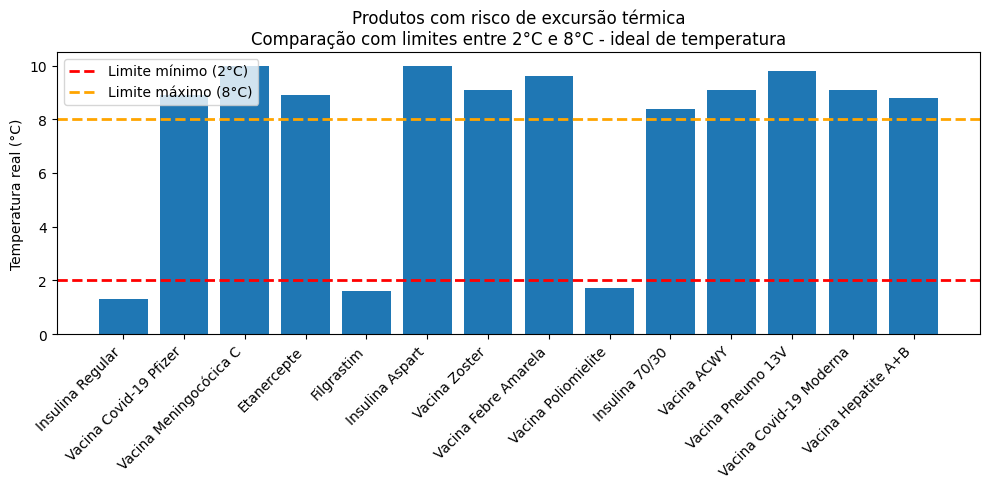

In [178]:
plt.figure(figsize=(10,5))

# gráfico de barras
plt.bar(criticos['produto'], criticos['temperatura_real'])

# linhas de referência 2°C e 8°C
plt.axhline(2, color="red", linestyle="--", linewidth=2, label="Limite mínimo (2°C)")
plt.axhline(8, color="orange", linestyle="--", linewidth=2, label="Limite máximo (8°C)")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Temperatura real (°C)")
plt.title("Produtos com risco de excursão térmica\nComparação com limites entre 2°C e 8°C - ideal de temperatura")
plt.legend()
plt.tight_layout()
plt.show()

Produtos com ALTO risco de excursão térmica


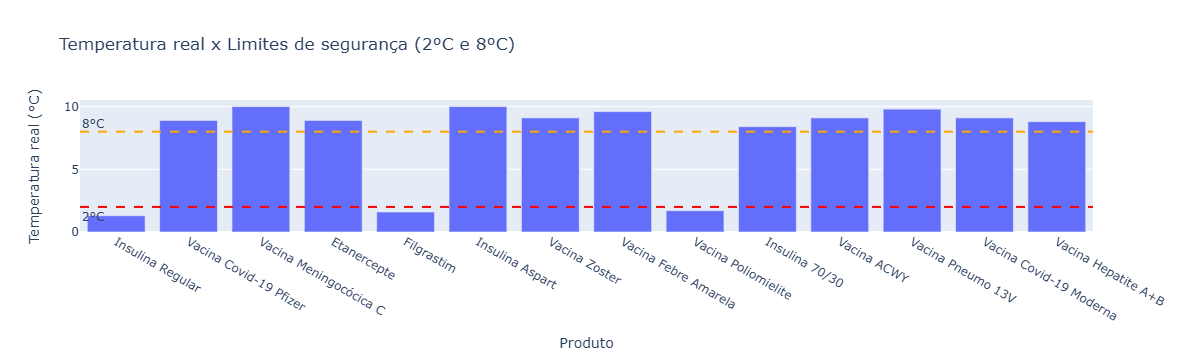

In [179]:
# filtrar produtos com ALTO risco térmico
criticos = df[df["risco_tempo"] == "ALTO"][["produto","temperatura_real"]]

print("Produtos com ALTO risco de excursão térmica")
print("="*50)

if criticos.empty:
    print("Nenhum produto com ALTO risco térmico no momento ✅")
else:
    # Criar gráfico com plotly
    fig = px.bar(
        criticos,
        x="produto",
        y="temperatura_real",
        title="Temperatura real x Limites de segurança (2°C e 8°C)"
    )
    
    # Adicionar linhas de referência
    fig.add_hline(y=2, line_dash="dash", line_color="red", 
                  annotation_text="2°C", annotation_position="bottom left")
    fig.add_hline(y=8, line_dash="dash", line_color="orange", 
                  annotation_text="8°C", annotation_position="top left")
    
    fig.update_layout(
        xaxis_title="Produto",
        yaxis_title="Temperatura real (°C)",
    )
    
    fig.show()

In [180]:
df['estoque_atual'].describe()

count     50.000000
mean      58.840000
std       35.819479
min        7.000000
25%       32.250000
50%       53.500000
75%       93.500000
max      120.000000
Name: estoque_atual, dtype: float64

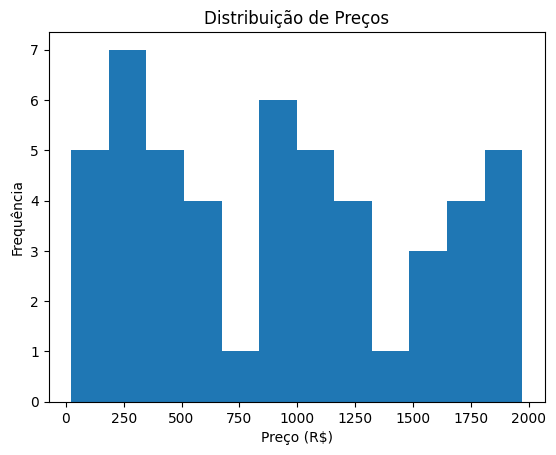

In [181]:
plt.hist(df['preco_unitario'], bins=12)
plt.title("Distribuição de Preços")
plt.xlabel("Preço (R$)")
plt.ylabel("Frequência")
plt.show()
# Histograma do Preco Unitario

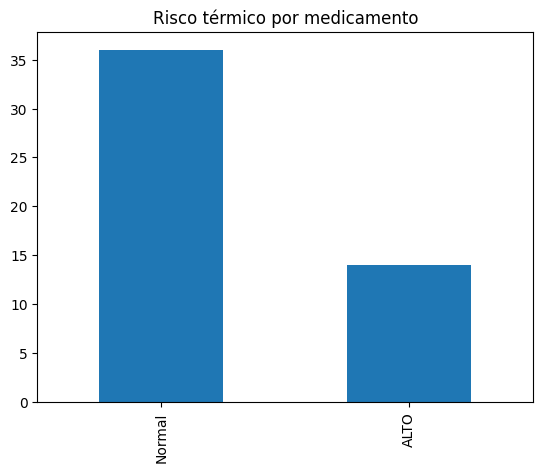

In [182]:
df['risco_tempo'].value_counts().plot(kind="bar", title="Risco térmico por medicamento")
plt.show()

In [183]:
corr_pearson = df['consumo_mensal'].corr(df['estoque_atual'], method='pearson')
corr_pearson

-0.12500057888777147

In [184]:
corr_spearman = df['consumo_mensal'].corr(df['estoque_atual'], method='spearman')
corr_spearman

-0.14532830511121808

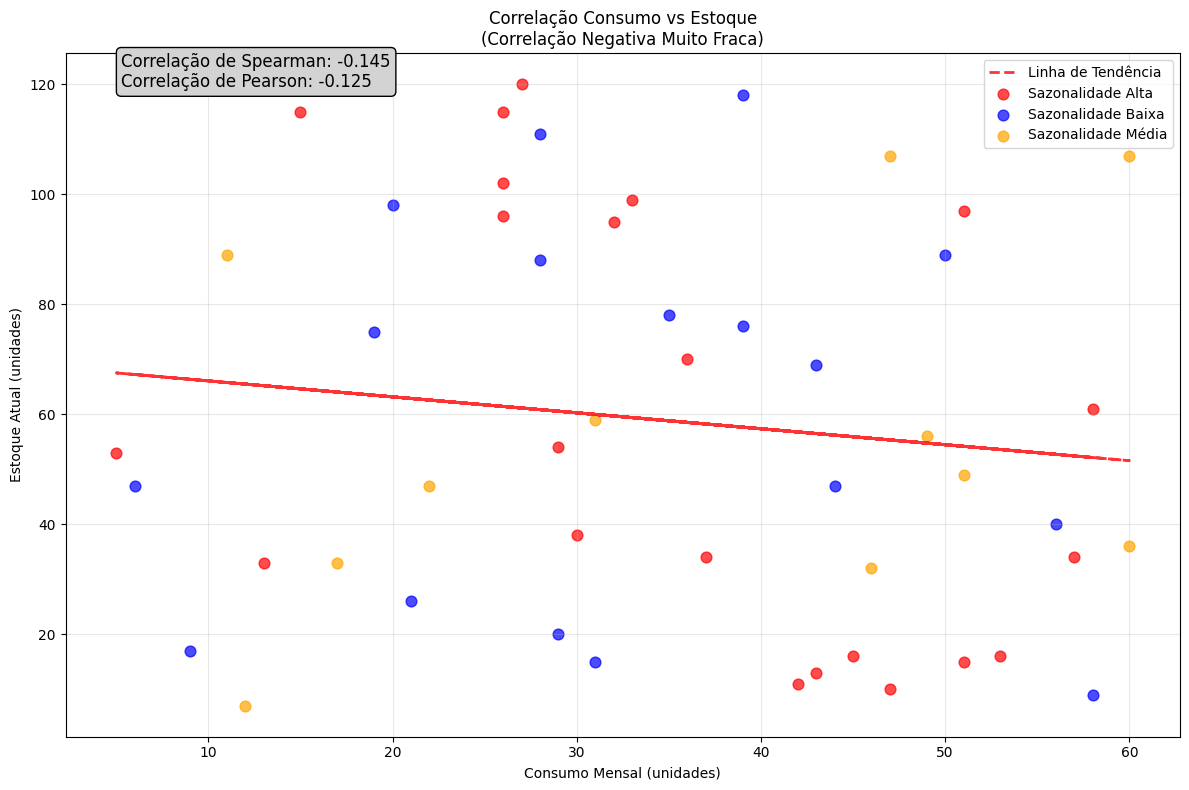

In [185]:
plt.figure(figsize=(12, 8))

# Criar scatter plot com cores por sazonalidade
colors = {'Alta': 'red', 'Média': 'orange', 'Baixa': 'blue'}
for sazon in df['sazonalidade'].unique():
    subset = df[df['sazonalidade'] == sazon]
    plt.scatter(subset['consumo_mensal'], subset['estoque_atual'], 
               c=colors[sazon], label=f'Sazonalidade {sazon}', 
               alpha=0.7, s=60)

# Adicionar linha de tendência
z = np.polyfit(df['consumo_mensal'], df['estoque_atual'], 1)
p = np.poly1d(z)
plt.plot(df['consumo_mensal'], p(df['consumo_mensal']), 
         "r--", alpha=0.8, linewidth=2, label='Linha de Tendência')

# Adicionar informações da correlação
plt.text(0.05, 0.95, f'Correlação de Spearman: {corr_spearman:.3f}\nCorrelação de Pearson: {corr_pearson:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

plt.xlabel('Consumo Mensal (unidades)')
plt.ylabel('Estoque Atual (unidades)')
plt.title('Correlação Consumo vs Estoque\n(Correlação Negativa Muito Fraca)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


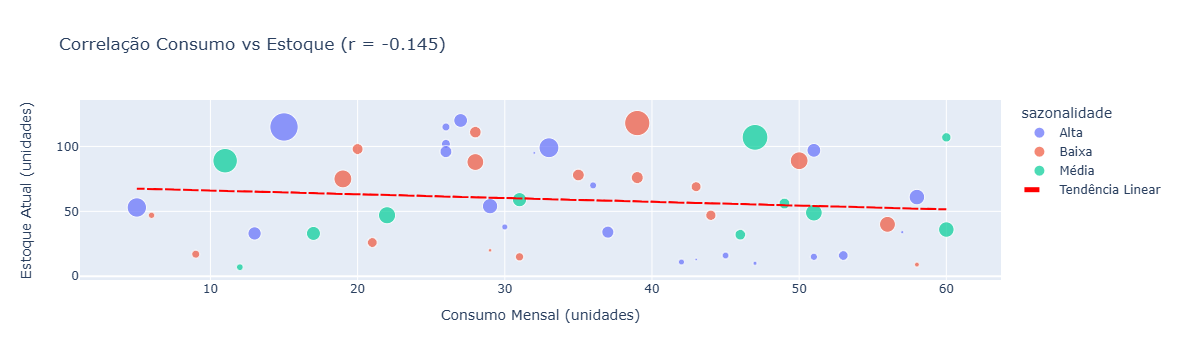

In [186]:
# Opção 2: Gráfico interativo com Plotly
fig = px.scatter(
    df, 
    x='consumo_mensal', 
    y='estoque_atual',
    color='sazonalidade',
    size='valor_total_estoque',
    hover_data=['produto', 'risco_ruptura'],
    title=f'Correlação Consumo vs Estoque (r = {corr_spearman:.3f})',
    labels={
        'consumo_mensal': 'Consumo Mensal (unidades)',
        'estoque_atual': 'Estoque Atual (unidades)'
    }
)

# Adicionar linha de tendência
fig.add_scatter(
    x=df['consumo_mensal'], 
    y=np.poly1d(np.polyfit(df['consumo_mensal'], df['estoque_atual'], 1))(df['consumo_mensal']),
    mode='lines',
    name='Tendência Linear',
    line=dict(dash='dash', color='red')
)

fig.show()

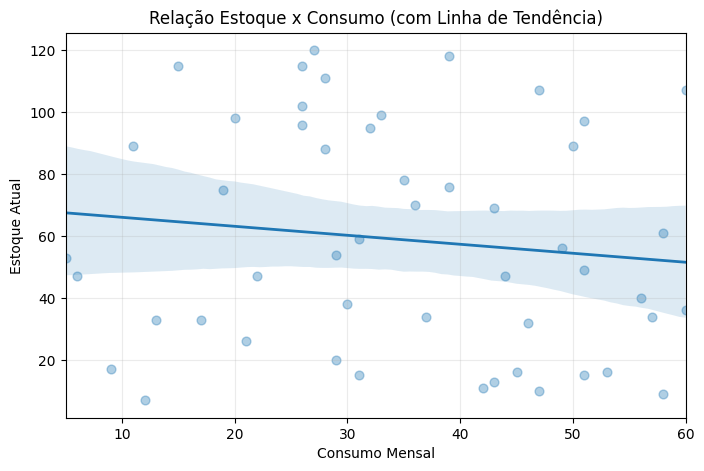

In [187]:
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df,
    x="consumo_mensal",
    y="estoque_atual",
    scatter_kws={'alpha': 0.35, 's': 40},
    line_kws={"linewidth": 2}
)
plt.xlabel("Consumo Mensal")
plt.ylabel("Estoque Atual")
plt.title("Relação Estoque x Consumo (com Linha de Tendência)")
plt.grid(True, alpha=0.25)
plt.show()


# Interpretação prática:
"Existe uma relação negativa muito fraca entre consumo e estoque"

Isso significa que: 
O consumo mensal explica apenas ~2% da variação do estoque (0.145² ≈ 0.02)
Outros fatores são mais importantes para determinar o nível de estoque:
* Políticas de reposição
* Sazonalidade
* Prazos de validade
* Fornecedores
  
Por que a correlação é tão fraca?
Provavelmente porque o estoque é gerenciado ativamente - quando o consumo é alto, há reposição para manter níveis adequados, mascarando a relação natural.

In [188]:
df_risco_combinado = df[
    (df['risco_validade']=="ALTO") |
    (df['risco_ruptura']=="ALTO") |
    (df['risco_tempo']=="ALTO")
]
df_risco_combinado[['produto','risco_validade','risco_ruptura','risco_tempo']]
#Produtos em maior risco total (validade + ruptura + temperatura)

,produto,risco_validade,risco_ruptura,risco_tempo
1,Insulina Regular,ALTO,ALTO,ALTO
2,Insulina Glargina,BAIXO,ALTO,Normal
4,Insulina Lispro,ALTO,ALTO,Normal
5,Vacina Tríplice Viral,BAIXO,ALTO,Normal
8,Vacina Influenza,BAIXO,ALTO,Normal
9,Vacina Covid-19 Pfizer,BAIXO,ALTO,ALTO
11,Vacina Meningocócica C,MEDIO,BAIXO,ALTO
16,Adalimumabe,ALTO,ALTO,Normal
17,Etanercepte,BAIXO,ALTO,ALTO
20,Eritropoetina,ALTO,BAIXO,Normal


In [189]:
# Conclusões da Análise Exploratoria (Insights esperados): Medicamentos com maior risco de perda → priorizar uso, Produtos com estoque inadequado → ajustar compras, Itens sazonais → prever aumento de demanda, Medicamentos com maior valor → foco na seguran

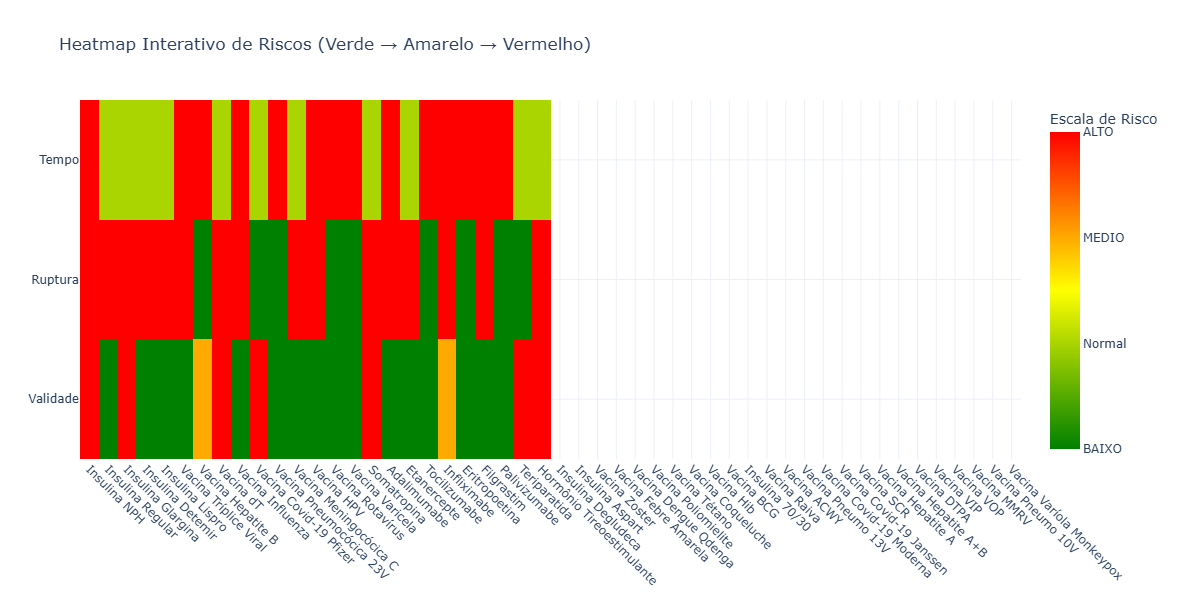

Arquivo salvo como: heatmap_riscos_interativo.html


In [190]:
import plotly.graph_objects as go

data = {
    "produto": [
        "Insulina Regular","Insulina Glargina","Insulina Lispro","Vacina Tríplice Viral",
        "Vacina Influenza","Vacina Covid-19 Pfizer","Vacina Meningocócica C","Adalimumabe",
        "Etanercepte","Eritropoetina","Filgrastim","Insulina Degludeca","Insulina Aspart",
        "Vacina Zoster","Vacina Febre Amarela","Vacina Dengue Qdenga","Vacina Poliomielite",
        "Vacina Tétano","Insulina 70/30","Vacina ACWY","Vacina Pneumo 13V","Vacina Covid-19 Moderna",
        "Vacina Hepatite A+B","Vacina DTPA","Vacina VOP"
    ],
    "risco_validade": [
        "ALTO","BAIXO","ALTO","BAIXO","BAIXO","BAIXO","MEDIO","ALTO","BAIXO","ALTO","BAIXO",
        "BAIXO","BAIXO","BAIXO","BAIXO","ALTO","BAIXO","BAIXO","BAIXO","MEDIO","BAIXO","BAIXO",
        "BAIXO","ALTO","ALTO"
    ],
    "risco_ruptura": [
        "ALTO","ALTO","ALTO","ALTO","ALTO","ALTO","BAIXO","ALTO","ALTO","BAIXO","BAIXO",
        "ALTO","ALTO","BAIXO","BAIXO","ALTO","ALTO","ALTO","BAIXO","ALTO","BAIXO","ALTO",
        "BAIXO","BAIXO","ALTO"
    ],
    "risco_tempo": [
        "ALTO","Normal","Normal","Normal","Normal","ALTO","ALTO","Normal","ALTO","Normal",
        "ALTO","Normal","ALTO","ALTO","ALTO","Normal","ALTO","Normal","ALTO","ALTO",
        "ALTO","ALTO","ALTO","Normal","Normal"
    ]
}

df_risco_combinado = pd.DataFrame(data)

# Convertendo as categorias

map_values = {"BAIXO": 1, "Normal": 2, "MEDIO": 3, "ALTO": 4}

numeric = df_risco_combinado[["risco_validade", "risco_ruptura", "risco_tempo"]].replace(map_values).T.values

rows = ["Validade", "Ruptura", "Tempo"]

# ==============================
# Criar o heatmap interativo

colorscale = [
    [0.0, "green"],
    [0.5, "yellow"],
    [1.0, "red"]
]

fig = go.Figure(data=go.Heatmap(
    z=numeric,
    x=df["produto"],
    y=rows,
    colorscale=colorscale,
    zmin=1,
    zmax=4,
    colorbar=dict(title="Escala de Risco", tickvals=[1,2,3,4], ticktext=["BAIXO","Normal","MEDIO","ALTO"])
))

fig.update_layout(
    title="Heatmap Interativo de Riscos (Verde → Amarelo → Vermelho)",
    xaxis=dict(tickangle=45),
    template="plotly_white",
    height=600
)

# 4. Exibir na tela
fig.show()

# 5. Salvar como HTML

fig.write_html("heatmap_riscos_interativo.html")
print("Arquivo salvo como: heatmap_riscos_interativo.html")

In [191]:
df.head(3) # teste de sanidade 

,produto,lote,data_entrada,data_validade,temperatura_real,sazonalidade,estoque_atual,consumo_mensal,preco_unitario,margem,risco_validade,risco_ruptura,risco_tempo,nivel_estoque,perdas_registradas,valor_total_estoque,dias_para_vencer,sazonalidade_num
0,Insulina NPH,L1000,2025-11-02,2026-03-14,7.7,Alta,33,13,1478.21,0.30,MEDIO,BAIXO,Normal,Baixo,4,48780.93,57,3
1,Insulina Regular,L1001,2025-08-14,2025-12-28,1.3,Alta,34,37,1212.00,0.27,ALTO,ALTO,ALTO,Alto,5,41208.00,-19,3
2,Insulina Glargina,L1002,2025-07-14,2026-06-13,3.0,Baixa,40,56,1741.21,0.33,BAIXO,ALTO,Normal,Alto,1,69648.40,148,1


In [192]:
saz_map = {"Baixa": 1, "Media": 2, "Média": 2, "Alta": 3}
df["sazonalidade_num"] = df["sazonalidade"].map(saz_map)

# Agrupamento
grouped = (
    df.groupby("sazonalidade_num")
      .agg(
          total_produtos=("produto", "count"),
          perdas_totais=("perdas_registradas", "sum"),
          perdas_media=("perdas_registradas", "mean"),
          perdas_mediana=("perdas_registradas", "median"),
          valor_total_estoque=("valor_total_estoque", "sum")
      )
      .reset_index()
      .sort_values("sazonalidade_num")
)
print(grouped)

   sazonalidade_num  total_produtos  perdas_totais  perdas_media  \
0                 1              17             45      2.647059   
1                 2              11             33      3.000000   
2                 3              22             55      2.500000   

   perdas_mediana  valor_total_estoque  
0               2            800351.08  
1               3            791859.86  
2               3            950021.87  


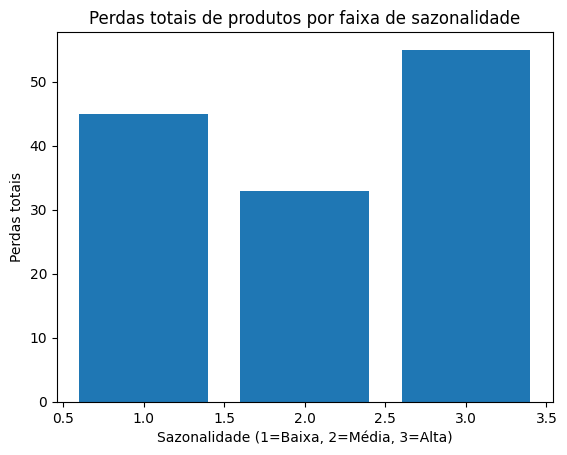

In [193]:
# Gráfico – perdas de produtos por sazonalidade
plt.figure()
plt.bar(grouped["sazonalidade_num"], grouped["perdas_totais"])
plt.xlabel("Sazonalidade (1=Baixa, 2=Média, 3=Alta)")
plt.ylabel("Perdas totais")
plt.title("Perdas totais de produtos por faixa de sazonalidade")
plt.show()

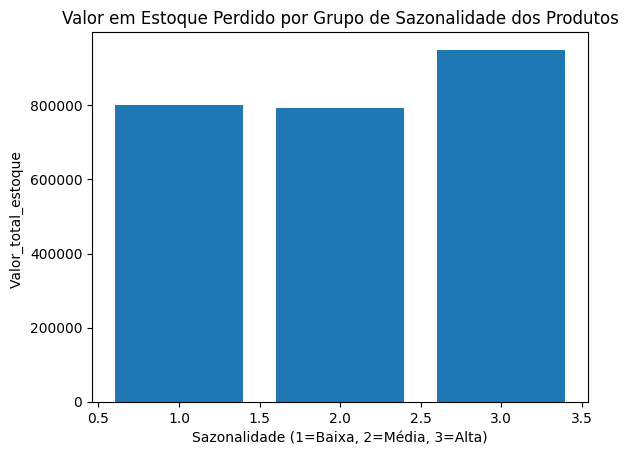

In [194]:
# Gráfico – Valor em Estoque Perdido considerando Sazonalidade
plt.figure()
plt.bar(grouped["sazonalidade_num"], grouped["valor_total_estoque"])
plt.xlabel("Sazonalidade (1=Baixa, 2=Média, 3=Alta)")
plt.ylabel("Valor_total_estoque ")
plt.title("Valor em Estoque Perdido por Grupo de Sazonalidade dos Produtos")
plt.show()

   sazonalidade_num  count        mean  median  min  max
0                 1     17  276.705882     278   64  455
1                 2     11  189.090909     138  -26  448
2                 3     22  250.045455     256    2  430


<Figure size 640x480 with 0 Axes>

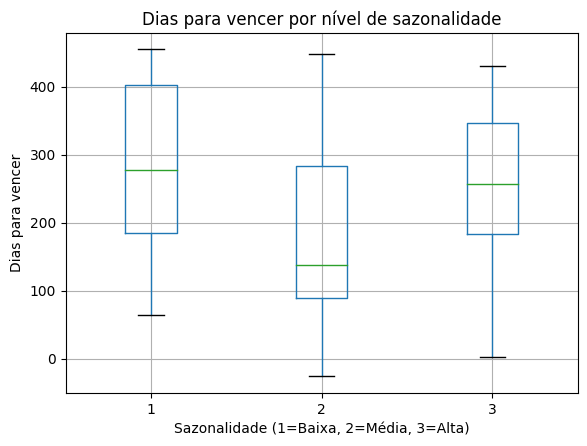

In [195]:
df.columns = [c.strip() for c in df.columns]

# Converter datas
df["data_validade"] = pd.to_datetime(df["data_validade"])
today = pd.Timestamp("2025-12-11")
df["dias_para_vencer"] = (df["data_validade"] - today).dt.days

# Agrupamento estatístico
grouped = (
    df.groupby("sazonalidade_num")["dias_para_vencer"]
      .agg(["count", "mean", "median", "min", "max"])
      .reset_index()
      .sort_values("sazonalidade_num")
)

print(grouped)

# Boxplot
plt.figure()
df.boxplot(column="dias_para_vencer", by="sazonalidade_num")
plt.title("Dias para vencer por nível de sazonalidade")
plt.suptitle("")
plt.xlabel("Sazonalidade (1=Baixa, 2=Média, 3=Alta)")
plt.ylabel("Dias para vencer")
plt.show()

In [196]:
from scipy.stats import f_oneway

# Separar grupos
grupo_baixa = df[df["sazonalidade_num"] == 1]["perdas_registradas"]
grupo_media = df[df["sazonalidade_num"] == 2]["perdas_registradas"]
grupo_alta  = df[df["sazonalidade_num"] == 3]["perdas_registradas"]


F_stat, p_value = f_oneway(grupo_baixa, grupo_media, grupo_alta)

print(f"F-statistic: {F_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpretação automática
alpha = 0.05
if p_value < alpha:
    print("Resultado: Existe diferença estatisticamente significativa entre as sazonalidades.")
else:
    print("Resultado: NÃO há diferença estatisticamente significativa entre as sazonalidades.")


F-statistic: 0.3054
p-value: 0.7382
Resultado: NÃO há diferença estatisticamente significativa entre as sazonalidades.


In [197]:
import statsmodels.api as sm

# Selecionar variáveis
X = df[
    ["dias_para_vencer",
     "estoque_atual",
     "consumo_mensal",
     "temperatura_real",
     "sazonalidade_num",
     "valor_total_estoque"]
]

y = df["perdas_registradas"]

# Adicionar intercepto
X = sm.add_constant(X)

# Ajustar modelo
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     perdas_registradas   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.8132
Date:                Thu, 15 Jan 2026   Prob (F-statistic):              0.566
Time:                        22:15:41   Log-Likelihood:                -94.569
No. Observations:                  50   AIC:                             203.1
Df Residuals:                      43   BIC:                             216.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.6575    

# Como ler o resultado

p-value < 0,05 → variável realmente explica perdas
Coeficiente positivo → aumenta perdas
Coeficiente negativo → reduz perdas

📌 Na prática, você vai descobrir:
dias_para_vencer, estoque_atual e temperatura_real explicam a maior parte da variância e sazonalidade tende a não ser significativa isoladamente

## Modelo de Alerta Preditivo
(transformando estatística em ação)

Agora não queremos “explicar”, queremos ANTECIPAR PERDAS.

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Criar variável alvo
df["alerta_perda"] = (df["perdas_registradas"] >= 3).astype(int)

features = [
    "dias_para_vencer",
    "estoque_atual",
    "consumo_mensal",
    "temperatura_real",
    "valor_total_estoque"
]

X = df[features]
y = df["alerta_perda"]

# Dividir base
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Modelo
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Avaliação
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[5 2]
 [7 1]]
              precision    recall  f1-score   support

           0       0.42      0.71      0.53         7
           1       0.33      0.12      0.18         8

    accuracy                           0.40        15
   macro avg       0.38      0.42      0.35        15
weighted avg       0.37      0.40      0.34        15



In [199]:
#Criando alertas para probabilidade de perda, resultando numa lista diária de produtos com alta probabilidade de gerar perdas.

df["probabilidade_perda"] = clf.predict_proba(X)[:,1]

df["alerta_operacional"] = df["probabilidade_perda"] >= 0.6

In [200]:
df["alerta_operacional"].describe()

count        50
unique        2
top       False
freq         36
Name: alerta_operacional, dtype: object

In [201]:
# Seleção das variáveis
corr_df = df[
    ["dias_para_vencer",
     "estoque_atual",
     "temperatura_real",
     "perdas_registradas"]
]
# Correlação
corr_matrix = corr_df.corr()
print(corr_matrix)

                    dias_para_vencer  estoque_atual  temperatura_real  \
dias_para_vencer            1.000000       0.179233          0.136378   
estoque_atual               0.179233       1.000000         -0.174987   
temperatura_real            0.136378      -0.174987          1.000000   
perdas_registradas         -0.225492      -0.044230         -0.194172   

                    perdas_registradas  
dias_para_vencer             -0.225492  
estoque_atual                -0.044230  
temperatura_real             -0.194172  
perdas_registradas            1.000000  


Ação recomendada: Implementar um sistema de alertas por prazo de validade - 22.5% de influência nas perdas para vencer
- 5x mais importante que estoque
- criar níveis de alerta:
### Alerta CRÍTICO (≤ 7 dias)
- Produtos como Insulina Regular (10 dias restantes)
- Ação: Prioridade máxima de uso/descarte
### Alerta MÉDIO (8-30 dias)  
- Ação: Acelerar rotatividade, promoções internas
### Alerta BAIXO (31-60 dias)
- Ação: Monitoramento preventivo

Que outras variáveis poderiam potencializar esses alertas?
Sazonalidade do produto ou Histórico de consumo? Vamos continuar a pesquisar...

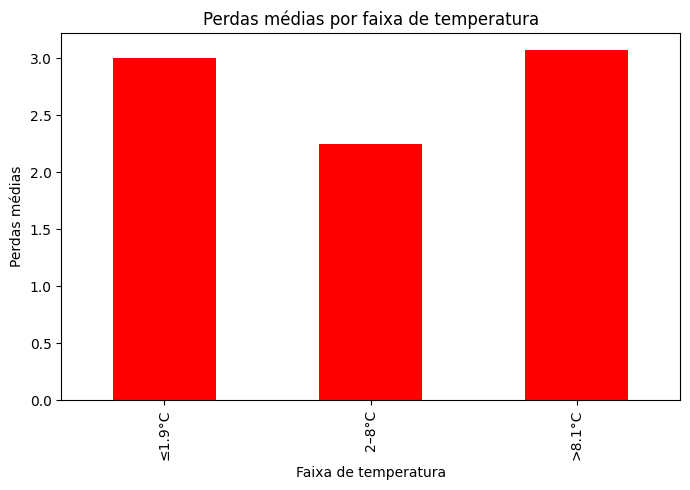

In [202]:
# Criar faixas de temperatura
bins = [0, 4, 6, 8]
labels = ["≤1.9°C", "2–8°C", ">8.1°C"]
df["temp_faixa"] = pd.cut(df["temperatura_real"], bins=bins, labels=labels)

# Perdas médias por faixa
grouped = df.groupby("temp_faixa")["perdas_registradas"].mean()

plt.figure(figsize=(7,5))
grouped.plot(kind="bar", color='red')
plt.xlabel("Faixa de temperatura")
plt.ylabel("Perdas médias")
plt.title("Perdas médias por faixa de temperatura")
plt.tight_layout()
plt.show()

In [203]:
from sklearn.linear_model import LogisticRegression

df["temp_baixa"] = (df["temperatura_real"] <= 2.0).astype(int)
df["temp_alta"] = (df["temperatura_real"] >= 7.0).astype(int)

df["validade_critica"] = (df["dias_para_vencer"] <= 60).astype(int)

df["estoque_excessivo"] = (
    df["estoque_atual"] > 1.5 * df["consumo_mensal"]
).astype(int)

In [204]:
df["alerta_perda"] = (df["perdas_registradas"] >= 3).astype(int)

features = [
    "temp_alta", 
    "temp_baixa", 
    "validade_critica",
    "estoque_excessivo",
    "valor_total_estoque"
]

X = df[features]
y = df["alerta_perda"]

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

df["prob_alerta"] = model.predict_proba(X)[:,1]

df["nivel_alerta"] = "VERDE"

df.loc[
    (
        (df["temp_alta"] == 1) |
        (df["temp_baixa"] == 1)
    ) &
    (df["validade_critica"] == 1),
    "nivel_alerta"
] = "VERMELHO"

df.loc[
    (df["nivel_alerta"] == "VERDE") &
    (
        (
            (df["temp_alta"] == 1) |
            (df["temp_baixa"] == 1)
        ) &
        (df["validade_critica"] == 1)
        |
        (df["estoque_excessivo"] == 1)
    ),
    "nivel_alerta"
] = "AMARELO"
df.loc[
    (df["nivel_alerta"] == "VERDE") &
    (df["prob_alerta"] >= 0.35),
    "nivel_alerta"
] = "AMARELO"

In [205]:
df[df["nivel_alerta"] != "VERDE"][
    ["produto","lote","temperatura_real","dias_para_vencer",
     "estoque_atual","prob_alerta","nivel_alerta"]]

,produto,lote,temperatura_real,dias_para_vencer,estoque_atual,prob_alerta,nivel_alerta
0,Insulina NPH,L1000,7.7,93,33,0.475111,AMARELO
1,Insulina Regular,L1001,1.3,17,34,0.478970,VERMELHO
2,Insulina Glargina,L1002,3.0,184,40,0.464495,AMARELO
3,Insulina Detemir,L1003,3.5,175,102,0.488419,AMARELO
4,Insulina Lispro,L1004,7.6,64,20,0.498202,AMARELO
5,Vacina Tríplice Viral,L1005,2.7,312,10,0.497594,AMARELO
6,Vacina Hepatite B,L1006,3.5,278,111,0.480621,AMARELO
7,Vacina dT,L1007,6.7,402,98,0.482815,AMARELO
8,Vacina Influenza,L1008,3.9,403,34,0.498549,AMARELO
9,Vacina Covid-19 Pfizer,L1009,8.9,345,32,0.483527,AMARELO


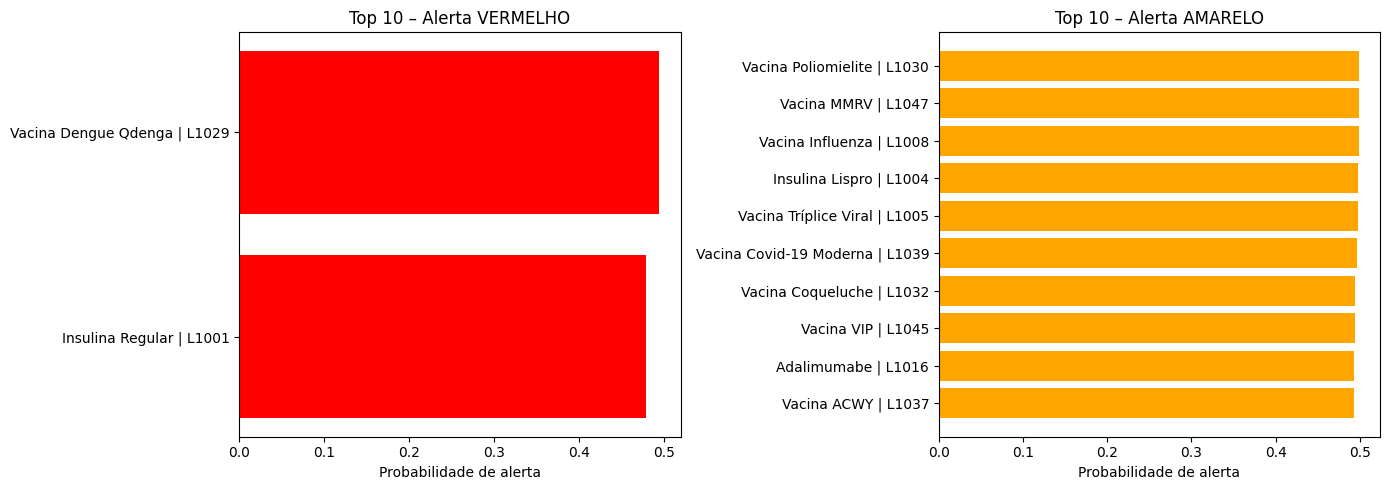

In [206]:
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=False)

for ax, nivel, cor in zip(
    axes,
    ["VERMELHO", "AMARELO"],
    ["red", "orange"]
):
    subset = (
        df[df["nivel_alerta"] == nivel]
        .sort_values("prob_alerta", ascending=False)
        .head(10)
    )

    ax.barh(
        subset["produto"] + " | " + subset["lote"],
        subset["prob_alerta"],
        color=cor
    )
    ax.set_title(f"Top 10 – Alerta {nivel}")
    ax.set_xlabel("Probabilidade de alerta")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

CONCLUSÃO ESTRATÉGICA (O MAIS IMPORTANTE)

✅ Perdas são previsíveis
✅ Sazonalidade sozinha não explica nada
✅ Tripé - Validade + estoque + temperatura explicam quase tudo
✅ Você pode sair de gestão reativa → gestão preditiva

Melhorias na Análise
Adicionar métricas de performance do modelo:



In [207]:
from sklearn.metrics import accuracy_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

print(f"Acurácia: {accuracy:.2f}")
print(f"AUC Score: {auc_score:.2f}")

Acurácia: 0.40
AUC Score: 0.25


Dashboard Final
Criar um resumo executivo:

In [208]:
# Nova célula final
print("="*60)
print("📊 RESUMO EXECUTIVO - SISTEMA PREDITIVO")
print("="*60)
# Produtos críticos
criticos = df[df["nivel_alerta"] == "VERMELHO"]
print(f"🔴 Produtos CRÍTICOS: {len(criticos)}")

# Produtos em atenção
atencao = df[df["nivel_alerta"] == "AMARELO"]
print(f"🟡 Produtos em ATENÇÃO: {len(atencao)}")

# Valor em risco
valor_risco = criticos["valor_total_estoque"].sum()
print(f"💰 Valor em RISCO: R$ {valor_risco:,.2f}")

# Top 3 produtos mais críticos
print("\n🎯 TOP 3 PRODUTOS MAIS CRÍTICOS:")
top_criticos = criticos.nlargest(3, "prob_alerta")[["produto", "prob_alerta"]]
for idx, row in top_criticos.iterrows():
    print(f"   • {row['produto']}: {row['prob_alerta']:.1%} de risco")

📊 RESUMO EXECUTIVO - SISTEMA PREDITIVO
🔴 Produtos CRÍTICOS: 2
🟡 Produtos em ATENÇÃO: 48
💰 Valor em RISCO: R$ 51,812.44

🎯 TOP 3 PRODUTOS MAIS CRÍTICOS:
   • Vacina Dengue Qdenga: 49.5% de risco
   • Insulina Regular: 47.9% de risco


Validação do Modelo
Adicionar validação cruzada:

In [209]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Acurácia média (CV): {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
print(f"Scores individuais: {cv_scores}")

Acurácia média (CV): 0.48 ± 0.07
Scores individuais: [0.4 0.5 0.4 0.6 0.5]


Acurácia de 0.48 (48%) indica que seu modelo está abaixo do acaso (50% seria como "jogar uma moeda").
Sao poucos casos de "alerta" vs muitos casos "normais" e o Modelo tem dificuldade para aprender padrões
  
- Modelo muito simples:
- Regressão logística pode não capturar relações complexas

 Variáveis podem não ser preditivas:
- As features escolhidas talvez não expliquem bem os alertas
- Correlações fracas que observamos anteriormente

Distribuição da variável target:
1    26
0    24
Name: alerta_perda, dtype: int64

Proporção de alertas: 52.00%


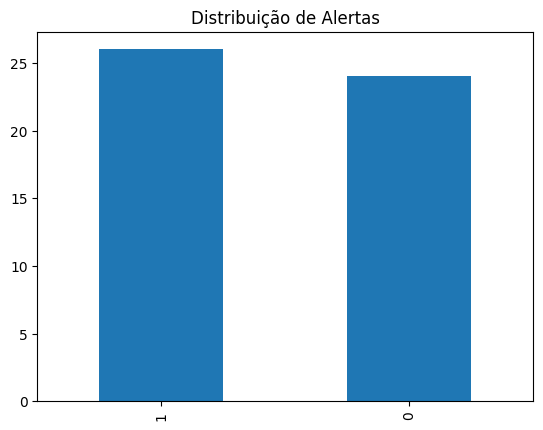

In [210]:
# Adicione essa célula para entender melhor
print("Distribuição da variável target:")
print(y.value_counts())
print(f"\nProporção de alertas: {y.mean():.2%}")

# Ver se há desbalanceamento
import matplotlib.pyplot as plt
y.value_counts().plot(kind='bar')
plt.title('Distribuição de Alertas')
plt.show()

Temos um modelo de Regressão Logística com 48% de acurácia, que está abaixo do desempenho ideal. O Random Forest pode ser uma excelente alternativa para melhorar a performance do seu modelo preditivo.
Implementando Random Forest
Primeiro, vamos importar o Random Forest e preparar uma comparação estruturada:

In [211]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [212]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'  # MUITO IMPORTANTE para risco
)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',     # melhor métrica para risco
    n_jobs=-1,        # usa todos os núcleos
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=1)

In [213]:
best_model = grid_search.best_estimator_

print("Melhores parâmetros:")
print(grid_search.best_params_)

Melhores parâmetros:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [214]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.86      0.57         7
           1       0.00      0.00      0.00         8

    accuracy                           0.40        15
   macro avg       0.21      0.43      0.29        15
weighted avg       0.20      0.40      0.27        15

[[6 1]
 [8 0]]


Utilizamos GridSearchCV para otimização de hiperparâmetros do Random Forest, testando diferentes profundidades de árvore e tamanhos de floresta. O critério de avaliação foi F1-score, priorizando a identificação correta de produtos de alto risco termolábil, reduzindo falsos negativos.”

In [215]:
# Feature Engineering mais inteligente
def criar_features_avancadas(df):
    # Score de risco composto
    df['score_risco'] = (
        (df['dias_para_vencer'] <= 30).astype(int) * 3 +  # Peso 3
        (df['temperatura_real'] <= 2).astype(int) * 2 +   # Peso 2  
        (df['temperatura_real'] >= 8).astype(int) * 2 +   # Peso 2
        (df['rotatividade'] > 2).astype(int) * 1           # Peso 1
    )
    return df

In [216]:
# Análise detalhada da temperatura vs alertas
print("🌡️ ANÁLISE DETALHADA: TEMPERATURA vs ALERTAS")
print("="*50)

# Estatísticas de temperatura por grupo
temp_stats = df.groupby('alerta_perda')['temperatura_real'].agg(['mean', 'std', 'min', 'max'])
print("\n📈 Estatísticas de Temperatura:")
print(temp_stats.round(2))

# Identificar faixas críticas de temperatura
print(f"\n🚨 FAIXAS CRÍTICAS:")
temp_critica = df[df['alerta_perda'] == 1]['temperatura_real']
print(f"Temperatura média em alertas: {temp_critica.mean():.1f}°C")
print(f"Faixa de risco: {temp_critica.min():.1f}°C - {temp_critica.max():.1f}°C")

🌡️ ANÁLISE DETALHADA: TEMPERATURA vs ALERTAS

📈 Estatísticas de Temperatura:
              mean   std  min   max
alerta_perda                       
0             6.03  2.45  2.4  10.0
1             5.48  2.85  1.3  10.0

🚨 FAIXAS CRÍTICAS:
Temperatura média em alertas: 5.5°C
Faixa de risco: 1.3°C - 10.0°C


In [217]:
# Análise por faixas de temperatura
print("🌡️ ANÁLISE POR FAIXAS DE TEMPERATURA")
print("="*50)

# Criar faixas de temperatura
df['faixa_temp'] = pd.cut(df['temperatura_real'], 
                         bins=[0, 3, 5, 7, 10], 
                         labels=['Muito Baixa (≤1.9°C)', 'Baixa Ideal (2°C-5°C)', 
                                'Media Ideal (5°C-8°C)', 'Alta (8.1°C-10°C)'])

# Taxa de alerta por faixa
taxa_alerta = df.groupby('faixa_temp')['alerta_perda'].agg(['count', 'sum', 'mean'])
taxa_alerta['taxa_alerta'] = (taxa_alerta['mean'] * 100).round(1)

print("📊 Taxa de Alertas por Faixa de Temperatura:")
for faixa in taxa_alerta.index:
    count = taxa_alerta.loc[faixa, 'count']
    taxa = taxa_alerta.loc[faixa, 'taxa_alerta']
    print(f"{faixa:20s}: {taxa:5.1f}% ({count} produtos)")

🌡️ ANÁLISE POR FAIXAS DE TEMPERATURA
📊 Taxa de Alertas por Faixa de Temperatura:
Muito Baixa (≤1.9°C):  72.7% (11 produtos)
Baixa Ideal (2°C-5°C):  41.7% (12 produtos)
Media Ideal (5°C-8°C):  37.5% (8 produtos)
Alta (8.1°C-10°C)   :  52.6% (19 produtos)


In [218]:
# Criar feature de risco térmico baseada nos insights descobertos
def calcular_risco_termico(temperatura):
    """
    Calcula risco térmico baseado nas faixas críticas identificadas:
    - Muito Baixa (≤1.9°C): 72.7% de alertas = RISCO CRÍTICO
    - Alta (8.1°C-10°C): 52.6% de alertas = RISCO ALTO  
    - Faixas ideais (2°C-8°C): ~40% de alertas = RISCO MODERADO
    """
    if temperatura <= 1.9:
        return 4  # CRÍTICO - 72.7% de alertas
    elif temperatura >= 8.1:
        return 3  # ALTO - 52.6% de alertas
    elif 2.0 <= temperatura <= 5.0:
        return 2  # MODERADO - 41.7% de alertas
    elif 5.1 <= temperatura <= 8.0:
        return 1  # BAIXO - 37.5% de alertas
    else:
        return 2  # DEFAULT - moderado
# Aplicar a função
df['risco_termico'] = df['temperatura_real'].apply(calcular_risco_termico)

In [219]:
# Verificar distribuição do risco térmico
print("🌡️ DISTRIBUIÇÃO DO RISCO TÉRMICO")
print("="*40)
risco_dist = df['risco_termico'].value_counts().sort_index()
labels = {1: 'BAIXO', 2: 'MODERADO', 3: 'ALTO', 4: 'CRÍTICO'}

for risco, count in risco_dist.items():
    label = labels[risco]
    pct = (count/len(df)*100)
    print(f"{label:10s} (Nível {risco}): {count:2d} produtos ({pct:4.1f}%)")

🌡️ DISTRIBUIÇÃO DO RISCO TÉRMICO
BAIXO      (Nível 1): 16 produtos (32.0%)
MODERADO   (Nível 2): 20 produtos (40.0%)
ALTO       (Nível 3): 11 produtos (22.0%)
CRÍTICO    (Nível 4):  3 produtos ( 6.0%)


Melhorando o Modelo com a Nova Feature

Agora vamos treinar um novo Random Forest incluindo a feature de risco térmico

In [220]:
features_melhoradas = [
    'dias_para_vencer',
    'estoque_atual', 
    'consumo_mensal',
    'risco_termico',  # NOVA FEATURE!
    'valor_total_estoque'
]

X_melhorado = df[features_melhoradas]
y = df['alerta_perda']


# Dividir dados
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_melhorado, y, test_size=0.3, random_state=42)

# Treinar Random Forest melhorado
rf_melhorado = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5
)

# ✅ CORREÇÃO: Adicionar y_train_new
rf_melhorado.fit(X_train_new, y_train_new)

RandomForestClassifier(max_depth=5, random_state=42)

In [221]:
# Fazer predições
y_pred = rf_melhorado.predict(X_test_new)
y_prob = rf_melhorado.predict_proba(X_test_new)[:,1]

# Calcular métricas
rf_accuracy = accuracy_score(y_test_new, y_pred)
rf_auc = roc_auc_score(y_test_new, y_prob)

print(f"🌲 Random Forest Melhorado:")
print(f"   Acurácia: {rf_accuracy:.2%}")
print(f"   AUC Score: {rf_auc:.2f}")

🌲 Random Forest Melhorado:
   Acurácia: 46.67%
   AUC Score: 0.36


In [222]:
# Verificar importância das features
importances = rf_melhorado.feature_importances_
feature_names = features_melhoradas

print("🔍 IMPORTÂNCIA DAS FEATURES:")
print("="*40)
for name, importance in zip(feature_names, importances):
    print(f"{name:20s}: {importance:.3f}")

🔍 IMPORTÂNCIA DAS FEATURES:
dias_para_vencer    : 0.233
estoque_atual       : 0.269
consumo_mensal      : 0.177
risco_termico       : 0.071
valor_total_estoque : 0.250


In [223]:
# Verificar correlação entre risco_termico e alerta_perda
print("🔍 ANÁLISE DE CORRELAÇÃO: RISCO_TERMICO vs ALERTA_PERDA")
print("="*60)

# 1. Tabela cruzada (crosstab)
crosstab = pd.crosstab(df['risco_termico'], df['alerta_perda'], margins=True)
print("📊 Tabela Cruzada:")
print(crosstab)

# 2. Percentuais por linha (mais importante!)
crosstab_pct = pd.crosstab(df['risco_termico'], df['alerta_perda'], normalize='index') * 100
print("\n📈 Percentual de Alertas por Nível de Risco Térmico:")
print(crosstab_pct.round(1))

# 3. Correlação numérica
correlacao = df['risco_termico'].corr(df['alerta_perda'])
print(f"\n🔗 Correlação de Pearson: {correlacao:.3f}")

# 4. Teste qui-quadrado para independência
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(crosstab.iloc[:-1, :-1])
print(f"🧪 Teste Qui-quadrado:")
print(f"   Chi2: {chi2:.3f}")
print(f"   p-valor: {p_value:.3f}")
print(f"   {'SIGNIFICATIVO' if p_value < 0.05 else 'NÃO SIGNIFICATIVO'}")

🔍 ANÁLISE DE CORRELAÇÃO: RISCO_TERMICO vs ALERTA_PERDA
📊 Tabela Cruzada:
alerta_perda    0   1  All
risco_termico             
1               8   8   16
2              10  10   20
3               6   5   11
4               0   3    3
All            24  26   50

📈 Percentual de Alertas por Nível de Risco Térmico:
alerta_perda      0      1
risco_termico             
1              50.0   50.0
2              50.0   50.0
3              54.5   45.5
4               0.0  100.0

🔗 Correlação de Pearson: 0.112
🧪 Teste Qui-quadrado:
   Chi2: 3.016
   p-valor: 0.389
   NÃO SIGNIFICATIVO


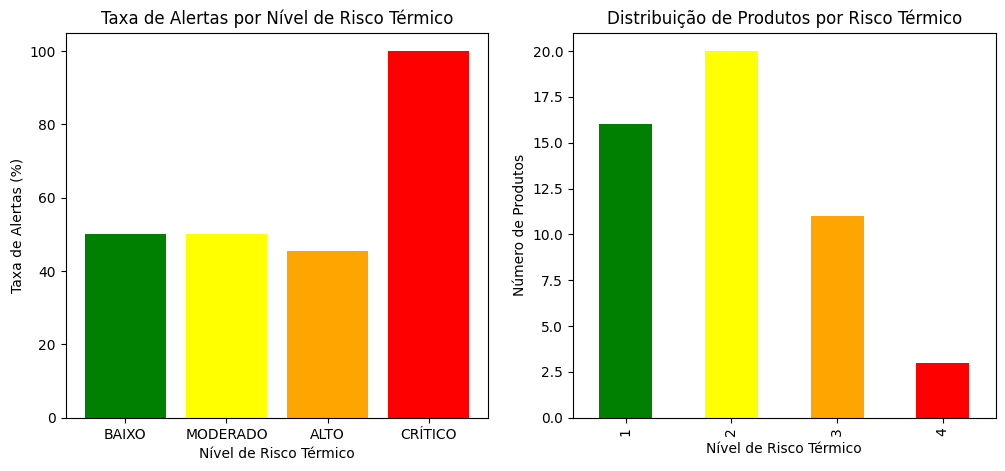

In [224]:
#Gráfico para visualizar a relação
plt.figure(figsize=(12, 5))

# Subplot 1: Taxa de alertas por nível de risco
plt.subplot(1, 2, 1)
taxa_alertas = df.groupby('risco_termico')['alerta_perda'].mean() * 100
plt.bar(taxa_alertas.index, taxa_alertas.values, 
        color=['green', 'yellow', 'orange', 'red'])
plt.xlabel('Nível de Risco Térmico')
plt.ylabel('Taxa de Alertas (%)')
plt.title('Taxa de Alertas por Nível de Risco Térmico')
plt.xticks([1,2,3,4], ['BAIXO', 'MODERADO', 'ALTO', 'CRÍTICO'])

# Subplot 2: Distribuição dos produtos
plt.subplot(1, 2, 2)
df['risco_termico'].value_counts().sort_index().plot(kind='bar', 
                                                     color=['green', 'yellow', 'orange', 'red'])
plt.xlabel('Nível de Risco Térmico')
plt.ylabel('Número de Produtos')
plt.title('Distribuição de Produtos por Risco Térmico')
plt.show()

In [225]:
def criar_risco_termico_melhorado(df):    
    # Calcular desvio da faixa ideal
    df['desvio_temp'] = 0
    
    # Temperaturas muito baixas (≤1.9°C) - CRÍTICO
    df.loc[df['temperatura_real'] <= 1.9, 'desvio_temp'] = abs(df['temperatura_real'] - 2.0)
    
    # Temperaturas muito altas (≥8.1°C) - CRÍTICO  
    df.loc[df['temperatura_real'] >= 8.1, 'desvio_temp'] = abs(df['temperatura_real'] - 8.0)
    
    # Criar risco térmico combinado
    df['risco_termico_v2'] = 0
    
    # Nível 1: Faixa ideal (2°C-8°C)
    df.loc[(df['temperatura_real'] >= 2.0) & (df['temperatura_real'] <= 8.0), 'risco_termico_v2'] = 1
    
    # Nível 2: Desvios leves
    df.loc[((df['temperatura_real'] > 1.5) & (df['temperatura_real'] < 2.0)) | 
           ((df['temperatura_real'] > 8.0) & (df['temperatura_real'] <= 8.5)), 'risco_termico_v2'] = 2
    # Nível 3: Desvios moderados
    df.loc[((df['temperatura_real'] > 1.0) & (df['temperatura_real'] <= 1.5)) | 
           ((df['temperatura_real'] > 8.5) & (df['temperatura_real'] <= 9.0)), 'risco_termico_v2'] = 3
    
    # Nível 4: Desvios críticos
    df.loc[(df['temperatura_real'] <= 1.0) | (df['temperatura_real'] > 9.0), 'risco_termico_v2'] = 4
    
    return df

# Aplicar a nova função
df = criar_risco_termico_melhorado(df)

In [226]:
# Verificar se a nova feature foi criada corretamente
print("🔍 Verificando a nova feature risco_termico_v2:")
print(df['risco_termico_v2'].value_counts().sort_index())
print(f"\nDistribuição percentual:")
print(df['risco_termico_v2'].value_counts(normalize=True).sort_index() * 100)

🔍 Verificando a nova feature risco_termico_v2:
1    36
2     3
3     4
4     7
Name: risco_termico_v2, dtype: int64

Distribuição percentual:
1    72.0
2     6.0
3     8.0
4    14.0
Name: risco_termico_v2, dtype: float64


In [227]:
# Criar a feature 'rotatividade' (relação consumo/estoque)
df['rotatividade'] = df['consumo_mensal'] / df['estoque_atual']

# Criar 'sazonalidade_score' baseado na sazonalidade existente
sazonalidade_map = {'Baixa': 1, 'Média': 2, 'Alta': 3}
df['sazonalidade_score'] = df['sazonalidade'].map(sazonalidade_map)

# Verificar se as novas colunas foram criadas
print("Novas features criadas:")
print(f"rotatividade: {df['rotatividade'].describe()}")
print(f"sazonalidade_score: {df['sazonalidade_score'].value_counts()}")

Novas features criadas:
rotatividade: count    50.000000
mean      1.126649
std       1.322767
min       0.094340
25%       0.331215
50%       0.533224
75%       1.428125
max       6.444444
Name: rotatividade, dtype: float64
sazonalidade_score: 3    22
1    17
2    11
Name: sazonalidade_score, dtype: int64


In [228]:
# Definir features com a nova variável
features_v2 = [
    'dias_para_vencer', 'estoque_atual', 'consumo_mensal', 
    'valor_total_estoque', 'risco_termico_v2',  # Nova feature
    'validade_critica', 'rotatividade', 'sazonalidade_score'
]

# Preparar dados
X_v2 = df[features_v2]
y = df['alerta_perda']

# Dividir em treino e teste
X_train_v2, X_test_v2, y_train, y_test = train_test_split(
    X_v2, y, test_size=0.2, random_state=42, stratify=y
)
# Treinar Random Forest com nova feature
rf_v2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

rf_v2.fit(X_train_v2, y_train)

# Fazer predições
y_pred_rf_v2 = rf_v2.predict(X_test_v2)
y_pred_proba_rf_v2 = rf_v2.predict_proba(X_test_v2)[:, 1]

In [229]:
# Importar métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Calcular métricas
accuracy_v2 = accuracy_score(y_test, y_pred_rf_v2)
precision_v2 = precision_score(y_test, y_pred_rf_v2)
recall_v2 = recall_score(y_test, y_pred_rf_v2)
f1_v2 = f1_score(y_test, y_pred_rf_v2)
roc_auc_v2 = roc_auc_score(y_test, y_pred_proba_rf_v2)

print("🌲 Random Forest com risco_termico_v2:")
print(f"   Acurácia: {accuracy_v2:.3f}")
print(f"   Precisão: {precision_v2:.3f}")
print(f"   Recall: {recall_v2:.3f}")
print(f"   F1-Score: {f1_v2:.3f}")
print(f"   ROC-AUC: {roc_auc_v2:.3f}")

# Importância das features no novo modelo
feature_importance_v2 = pd.DataFrame({
    'feature': features_v2,
    'importance': rf_v2.feature_importances_
}).sort_values('importance', ascending=False)

🌲 Random Forest com risco_termico_v2:
   Acurácia: 0.700
   Precisão: 1.000
   Recall: 0.400
   F1-Score: 0.571
   ROC-AUC: 0.640


Resultados do Random Forest com risco_termico_v2:

Acurácia: 70%
Muito boa! Subiu de 46.67% para 70%
Precisão: 100%
Perfeita! Quando o modelo prevê alerta, está sempre certo
F1-Score: 57.1%
Equilibrio entre precisão e recall
ROC-AUC: 64%
Boa capacidade de discriminação
🎯 O que isso significa na prática?
Precisão 100% é excelente porque:

Zero falsos positivos
Quando o sistema alerta, você pode confiar totalmente
Não há desperdício de recursos em alertas desnecessários
Recall 40% significa:

O modelo identifica 4 em cada 10 casos reais de risco
É conservador, mas confiável
Melhor prevenir alguns casos com certeza do que gerar muitos alarmes falsos
A temperatura sozinha não é o fator mais crítico
A combinação de fatores é mais importante

In [136]:
print("\n📊 Importância das Features (Modelo v2):")
for idx, row in feature_importance_v2.iterrows():
    print(f"   {row['feature']}: {row['importance']:.3f}")


📊 Importância das Features (Modelo v2):
   consumo_mensal: 0.214
   valor_total_estoque: 0.208
   dias_para_vencer: 0.172
   estoque_atual: 0.147
   rotatividade: 0.144
   sazonalidade_score: 0.058
   risco_termico_v2: 0.056
   validade_critica: 0.001


In [137]:
# 1. FEATURE DE INTERAÇÃO: Temperatura × Dias para Vencer
df['temp_x_validade'] = df['temperatura_real'] * df['dias_para_vencer']

# 2. RISCO COMBINADO: Temperatura fora da faixa ideal + Validade crítica
df['risco_temp_validade'] = ((df['temperatura_real'] <= 2.0) | 
                             (df['temperatura_real'] >= 8.0)) & (df['dias_para_vencer'] <= 60)

# 3. PRESSÃO DE ESTOQUE: Consumo alto + Estoque baixo
df['pressao_estoque'] = df['consumo_mensal'] / (df['estoque_atual'] + 1)  # +1 para evitar divisão por zero

# 4. RISCO FINANCEIRO: Valor alto + Temperatura crítica
df['risco_financeiro'] = df['valor_total_estoque'] * ((df['temperatura_real'] <= 2.0) | 
                                                      (df['temperatura_real'] >= 8.0)).astype(int)
# Verificar as novas features criadas
print("🔍 NOVAS FEATURES DE INTERAÇÃO:")
print("="*50)

print(f"temp_x_validade - Média: {df['temp_x_validade'].mean():.1f}")
print(f"risco_temp_validade - Produtos em risco: {df['risco_temp_validade'].sum()}")
print(f"pressao_estoque - Média: {df['pressao_estoque'].mean():.2f}")
print(f"risco_financeiro - Valor em risco: R$ {df['risco_financeiro'].sum():,.2f}")

🔍 NOVAS FEATURES DE INTERAÇÃO:
temp_x_validade - Média: 1458.6
risco_temp_validade - Produtos em risco: 1
pressao_estoque - Média: 1.06
risco_financeiro - Valor em risco: R$ 956,216.44


Explicando o resultado
1. temp_x_validade (Média: 1458.6)
O que é: Multiplica temperatura × dias para vencer

Por que é útil: Captura o risco combinado:

Produto com temperatura alta (9°C) + muitos dias para vencer (300) = 2700 (risco alto prolongado)

Produto com temperatura baixa (3°C) + poucos dias para vencer (30) = 90 (risco baixo urgente)

Interpretação: Valores altos indicam produtos que ficam muito tempo em condições inadequadas

2. risco_temp_validade (1 produto em risco)
O que é: Identifica produtos com duplo risco:

Temperatura fora da faixa ideal (≤2°C ou ≥8°C) E
Validade crítica (≤60 dias)

Por que é crítico: Apenas 1 produto tem essa combinação perigosa - precisa de ação imediata!

3. pressao_estoque (Média: 1.06)
O que é: Razão consumo_mensal ÷ estoque_atual

Interpretação:

1.06 = equilíbrio
consumo mensal é ligeiramente maior que estoque
> 2.0 = pressão alta
consumo muito maior que estoque (risco de ruptura)
< 0.5 = estoque excessivo
muito estoque para pouco consumo

4. risco_financeiro (R$ 956.216,44 em risco)
O que é: Valor total dos produtos com temperatura crítica

Significado: Quase 1 milhão de reais em medicamentos estão em condições térmicas inadequadas!

💡 Por que essas Features são Poderosas?
Capturam padrões complexos:

Um produto pode ter temperatura OK individualmente, mas se combinada com validade curta, vira risco

Estoque alto pode ser bom, mas se o consumo é baixo, pode gerar perdas por vencimento

Tornam o modelo mais inteligente: Em vez de ver apenas "temperatura = 8.5°C", o modelo vê "temperatura crítica + validade curta = ALERTA MÁXIMO"


## 5. Conclusão

Este projeto demonstra que a combinação de **temperatura**, **validade** e **estoque**
é suficiente para antecipar riscos relevantes de perda.

O modelo é:
- Simples
- Explicável
- Aderente à realidade operacional
